In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

In [2]:
def json_load_file(file):
    """
    Returns a Python's dict from a json file path.
    """
    with open(file) as json_file:
        return json.load(json_file)

In [3]:
def to_panda_dataframe(scores_json):
    data = [[student_id, *map(float, scores[:5]), scores[5]] for student_id, scores in scores_json.items()]
    df = pd.DataFrame.from_records(data, columns = ["Student ID", *[f"Question {i}" for i in range(1,7)]])
    df["Score"] = df["Question 1"] + df["Question 2"] + df["Question 3"] + df["Question 4"] + df['Question 5']
    df["Chapter"] = df["Student ID"].apply(lambda x: (int(x) - 1)%3 + 1)
    df["Method"] = df["Student ID"].apply(lambda x: 0 if int(x) <= 9 else 1)
    return df

In [4]:
def read_dataframe(school):
    return to_panda_dataframe(json_load_file(f"../data/manual/{school}/final_quizz_scores.json"))

In [5]:
piccard_data = read_dataframe("piccard")
beaulieu_data = read_dataframe("beaulieu")

In [6]:
data = pd.concat([piccard_data, beaulieu_data])

## Exploration

In [7]:
data.groupby("Method")["Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
0,15.0,2.253333,1.244340,0.6,1.2,2.0,2.95,5.0
1,19.0,1.736842,1.370406,0.0,0.6,1.4,3.00,4.0


### Distribution of students results for the quiz

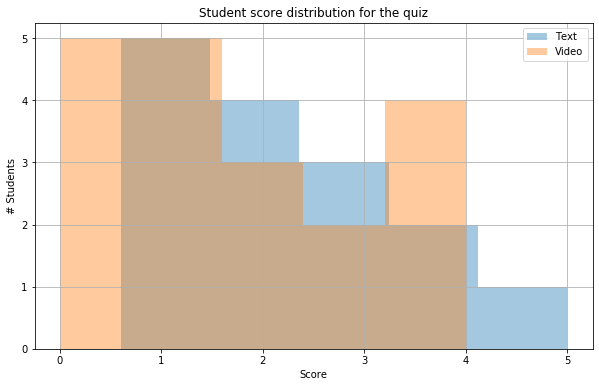

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
data.groupby('Method')['Score'].hist(alpha=0.4, bins=5, ax=ax)
ax.legend(['Text', 'Video'])
ax.set_ylabel('# Students')
ax.set_xlabel('Score')
ax.set_title('Student score distribution for the quiz')
fig.savefig(f"../data/derived/hist_quiz.jpg")

## Box-plot of results grouped by method

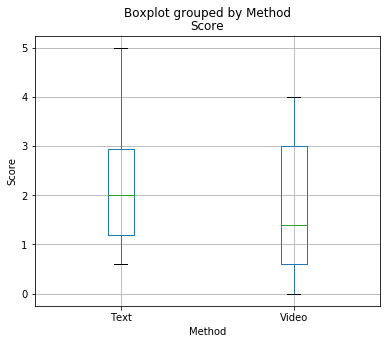

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
data.boxplot(column='Score', by='Method', ax=ax)
ax.set_xticklabels(labels=['Text', 'Video'])
ax.set_ylabel('Score')
fig.savefig(f"../data/derived/box_plot_quiz.jpg")

# Statistical tests
Recall our hypothesis:
- $\mathcal{H}_0$: There is no influence of the method on the results (same mean)
- $\mathcal{H}_1$: There is an influence of the method on the results (double tailed test)

We first want to check if our distribution could be normal (even if they don't really look like that)

Use Shapiro normality test with significance level of $0.1$:

In [10]:
from scipy.stats import mstats, shapiro

In [11]:
print('Text', shapiro(data[data.Method == 0].Score))
print('Video', shapiro(data[data.Method == 1].Score))

Text (0.9442788362503052, 0.43922388553619385)
Video (0.9137222766876221, 0.08666303008794785)


As the p-value for video is smaller than 0.1 we have to rejet the null hypothesis of the Shapiro test, hence the results of the Video group may not be normally distributed. Hence we need to use a non-parametric Test.

We thus use **Kruskal-Wallis** 

In [12]:
mstats.kruskalwallis(data[data.Method == 0].Score.to_numpy(), data[data.Method == 1].Score.to_numpy())

KruskalResult(statistic=0.9814917127071909, pvalue=0.32183080361992833)

Because the assumption of normality of the video results was not respected (W = 0.9137, p-value < .1) in our sample, we conducted a **non-parametric Kruskal-Wallis test** that showed that the mean rank of quiz results doesn't differs significantly across groups ($\chi^2$[1]=0.9815, p = .32)